# Lecture plots

**Goal:** Show some of visualizations to build some intuition for the plots and formulas

Nicole Hartman

Sept 2024

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchdiffeq import odeint

import torch.distributions as D
from torch.distributions.mixture_same_family import MixtureSameFamily

## Push forward definition

In [2]:
N = int(1e6)
x = np.random.randn(N)

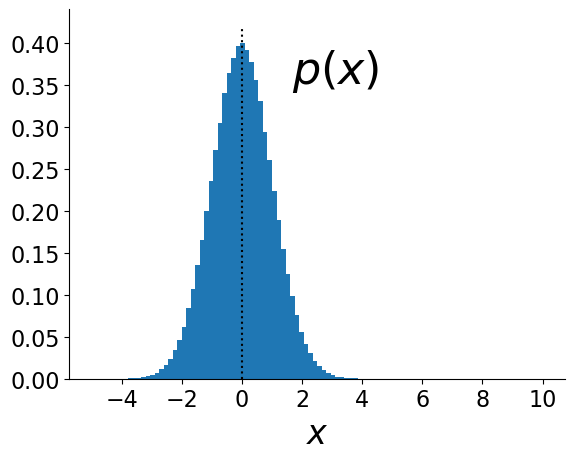

In [3]:
r = (-5,10)
plt.hist(x,100,r,density=True)
plt.xlabel('$x$',fontsize=24)
ax = plt.gca()
plt.text(0.45,.8,'$p(x)$',fontsize=32,color='k',
         transform=ax.transAxes)
ax.spines[['right', 'top']].set_visible(False)
plt.vlines(0,*plt.ylim(),'k',ls='dotted')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figures/p0.pdf',bbox_inches='tight')
plt.show()

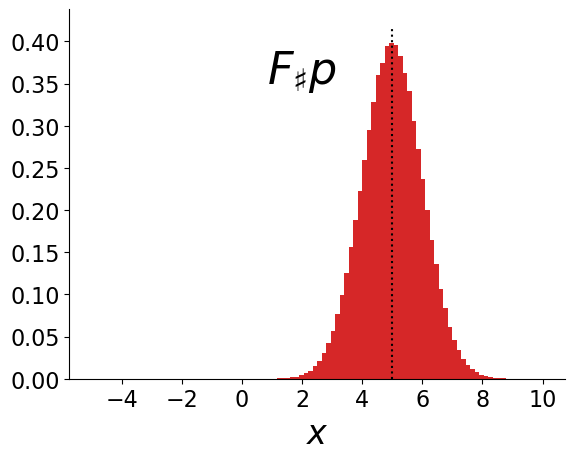

In [4]:
mu=5
plt.hist(x+mu,100,r,density=True,color='C3')
plt.xlabel('$x$',fontsize=24)
ax = plt.gca()
plt.text(0.4,.8,'$F_\sharp p$',fontsize=32,color='k',
         transform=ax.transAxes)
ax.spines[['right', 'top']].set_visible(False)
plt.vlines(5,*plt.ylim(),'k',ls='dotted')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ylim=plt.ylim()
plt.savefig('figures/F_p0_mu5.pdf',bbox_inches='tight')

plt.show()

### Your turn!

**Q1:** For $F(x) = \sigma * x + \mu$, what is $F_\sharp p$?


**Answer:**
$F_\sharp p = \mathcal{N}(\mu,\sigma)$

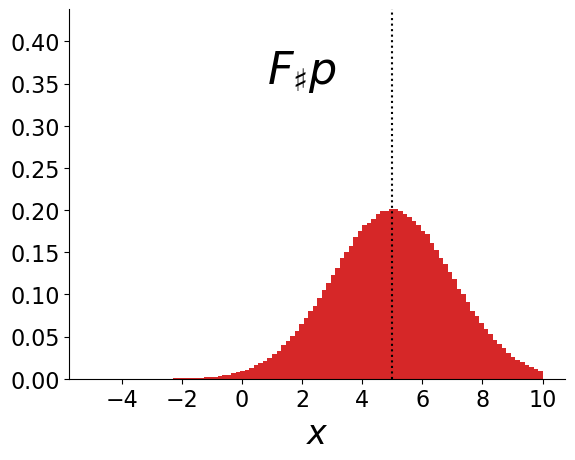

In [5]:
sigma=2
plt.hist(sigma*x+mu,100,r,density=True,color='C3')
plt.xlabel('$x$',fontsize=24)
ax = plt.gca()
plt.text(0.4,.8,'$F_\sharp p$',fontsize=32,color='k',
         transform=ax.transAxes)
ax.spines[['right', 'top']].set_visible(False)
plt.vlines(5,*ylim,'k',ls='dotted')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ylim)

plt.savefig('figures/F_p0_mu5_std2.pdf',bbox_inches='tight')
plt.show()

**Q2:** If $F(x) = x**2$, what is $F_\sharp p$?

**Answer:** $F_\sharp p = \chi^2(1)$, a chi^2 distribution w/ 1 dof

In [6]:
chi2 = D.Chi2(1)
xi = torch.linspace(0,5,101)
yi = torch.exp(chi2.log_prob(xi))

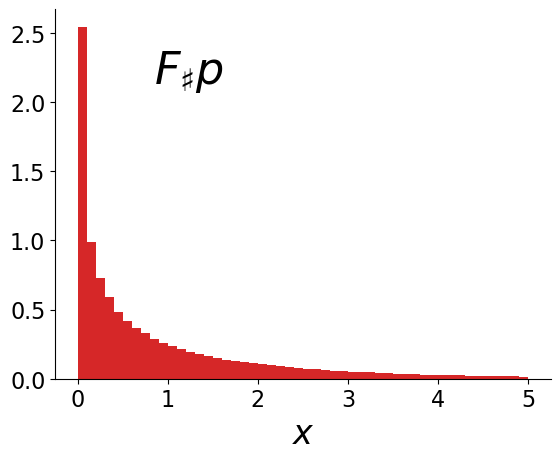

In [7]:
plt.hist(x**2,50,(0,5),density=True,color='C3')
plt.xlabel('$x$',fontsize=24)
# plt.xlim(0,5)

# plt.plot(xi,yi,'k')

ax = plt.gca()
plt.text(0.2,.8,'$F_\sharp p$',fontsize=32,color='k',
         transform=ax.transAxes)
ax.spines[['right', 'top']].set_visible(False)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('figures/F_p0_xSqd.pdf',bbox_inches='tight')
plt.show()

### Continuous family of distributions

In [8]:
import matplotlib as mpl
import matplotlib.animation as animation

In [9]:
cmap = mpl.colormaps['coolwarm']

**How to make a gif with a histogram**
- Following [stackoverflow](https://stackoverflow.com/questions/35108639/matplotlib-animated-histogram) suggestion
- Note, to get the animation to show up on my local conda installation I needed to install `ipympl`
`conda install -c conda-forge ipympl`


In [10]:
# %matplotlib notebook
# %matplotlib ipympl

MovieWriter ffmpeg unavailable; using Pillow instead.


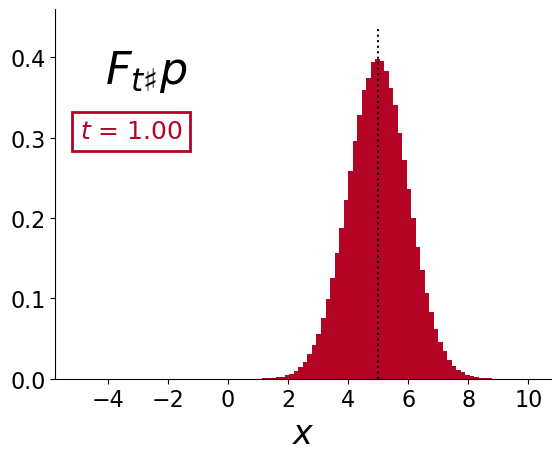

In [11]:
fig, ax = plt.subplots()

ax.spines[['right', 'top']].set_visible(False)

def update_hist(ti):
    plt.cla()

    mu_t = mu * ti
    ci = cmap(ti)
    
    plt.hist(x+mu_t,100,r,density=True,color=ci)

    plt.text(0.1,.8,'$F_{t \sharp} p$',fontsize=32,color='k',
             transform=ax.transAxes)

    plt.text(0.05,.65,f'$t$ = {ti:.2f}',fontsize=18,color=ci,
             transform=ax.transAxes,
             bbox=dict(boxstyle="square,pad=0.3",fc="w",ec=ci,lw=2))
        
    plt.vlines(mu_t,*ylim,'k',ls='dotted')
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xlabel('$x$',fontsize=24)


ani = animation.FuncAnimation(fig, update_hist, np.linspace(0,1),interval=100)
ani.save('figures/pt_ani.gif')
plt.show()

**Nice!!** And now make a 3d version of this plot

- Syntax reminder from [docs](https://matplotlib.org/stable/gallery/mplot3d/surface3d.html)

Let's draw the plot at the distribution level now

In [31]:
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0]),
    covariance_matrix=torch.tensor([[1.]])
)

p_z1 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([mu]),
    covariance_matrix=torch.tensor([[1.]])
)

p_zt = lambda ti: torch.distributions.MultivariateNormal(
                        loc=torch.tensor([mu*ti]),
                        covariance_matrix=torch.tensor([[1.]])
                    )

In [65]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

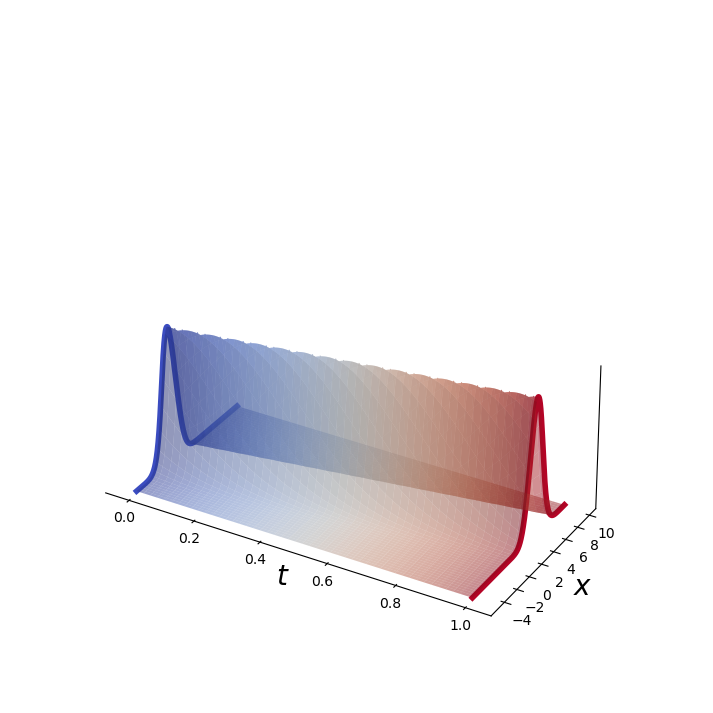

In [107]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
tt = torch.linspace(0,1,1001)
xx = torch.linspace(-5, 10, 1001)
t,X = np.meshgrid(tt,xx)

Z = np.column_stack([np.exp(p_zt(ti).log_prob(xx[:,None])) for ti in tt])

# Plot the surface.
ax.plot_surface(t,X, Z.reshape(t.shape), 
                facecolors=cmap(t),lw=0,
                # antialiased=False,
                alpha=.5
               )

ax.plot(np.zeros_like(xx)[:,None],
        xx[:,None], 
        np.exp(p_z0.log_prob(xx[:,None]))[:,None], 
        color=cmap(0),
        linewidth=4)


# Overlay the endpoints of the distribtuion
ax.plot(np.ones_like(xx)[:,None],
        xx[:,None], 
        np.exp(p_z1.log_prob(xx[:,None]))[:,None], 
        color=cmap(256),
        linewidth=4)

ax.set_xlabel('$t$',fontsize=20)
ax.set_ylabel('$x$',fontsize=20)

x_scale=2
y_scale=1
z_scale=1

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
fig.set_figwidth(16)
fig.set_figheight(9)

# Hide grid lines
ax.grid(False)

# Hide z-axis ticks
ax.set_zticks([])

# ax.spines['top'].set_visible('False')
# ax.xaxis._axinfo['juggled'] = (2,0,1)

# Make the bkg panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Alternatively, can turn everything off
# ax.set_axis_off()

plt.savefig('figures/interp_3d.pdf')


In [80]:
ax.spines?

Type:        Spines
String form: <matplotlib.spines.Spines object at 0x3194a2c90>
Length:      4
File:        ~/miniconda3/lib/python3.11/site-packages/matplotlib/spines.py
Docstring:  
The container of all `.Spine`\s in an Axes.

The interface is dict-like mapping names (e.g. 'left') to `.Spine` objects.
Additionally, it implements some pandas.Series-like features like accessing
elements by attribute::

    spines['top'].set_visible(False)
    spines.top.set_visible(False)

Multiple spines can be addressed simultaneously by passing a list::

    spines[['top', 'right']].set_visible(False)

Use an open slice to address all spines::

    spines[:].set_visible(False)

The latter two indexing methods will return a `SpinesProxy` that broadcasts
all ``set_*`` calls to its members, but cannot be used for any other
operation.

## Flow matching illustration

In [108]:
# xx = torch.linspace(-5,10,101)[:,None]
p_z0.log_prob(xx[:,None])

tensor([-13.4189, -13.3441, -13.2694,  ..., -50.6194, -50.7690, -50.9189])

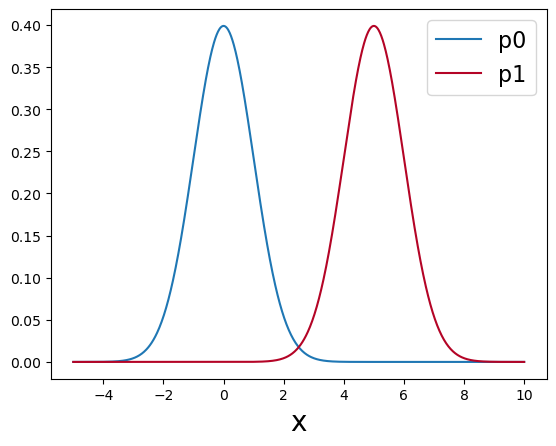

In [109]:
plt.plot(xx,torch.exp(p_z0.log_prob(xx[:,None])),label='p0')
plt.plot(xx,torch.exp(p_z1.log_prob(xx[:,None])),color=cmap(256),label='p1')
plt.legend(fontsize=16)
plt.xlabel('x',fontsize=20)
plt.show()

**Interpolating distributions**

OK, so given these two distributions, we can intuitively see that we 

$$p_t = \mathcal{N}(\mu(t),1), \qquad \mathrm{with} \ \mu(t) = \mu \cdot t.$$

Differntiating $F_t(x) = x+\mu_t = x + \mu \cdot t$ :

$$u_t = \frac{d x_t}{dt} = \frac{dF}{dt} = \frac{d}{dt} (x+\mu t) =  \mu.$$

So we can see we have a velocity field to c.f. one parametrized with a NN!


In [228]:
xt.shape

torch.Size([1, 50])

In [281]:
tt = torch.linspace(0.02,.9,8)
xt = torch.linspace(-2.25, 2.25, 5)

T,X = np.meshgrid(tt,xt)

T = torch.FloatTensor(T)
X = torch.FloatTensor(X) 
X += mu * tt

In [282]:
X.shape,tt.shape

(torch.Size([5, 8]), torch.Size([8]))

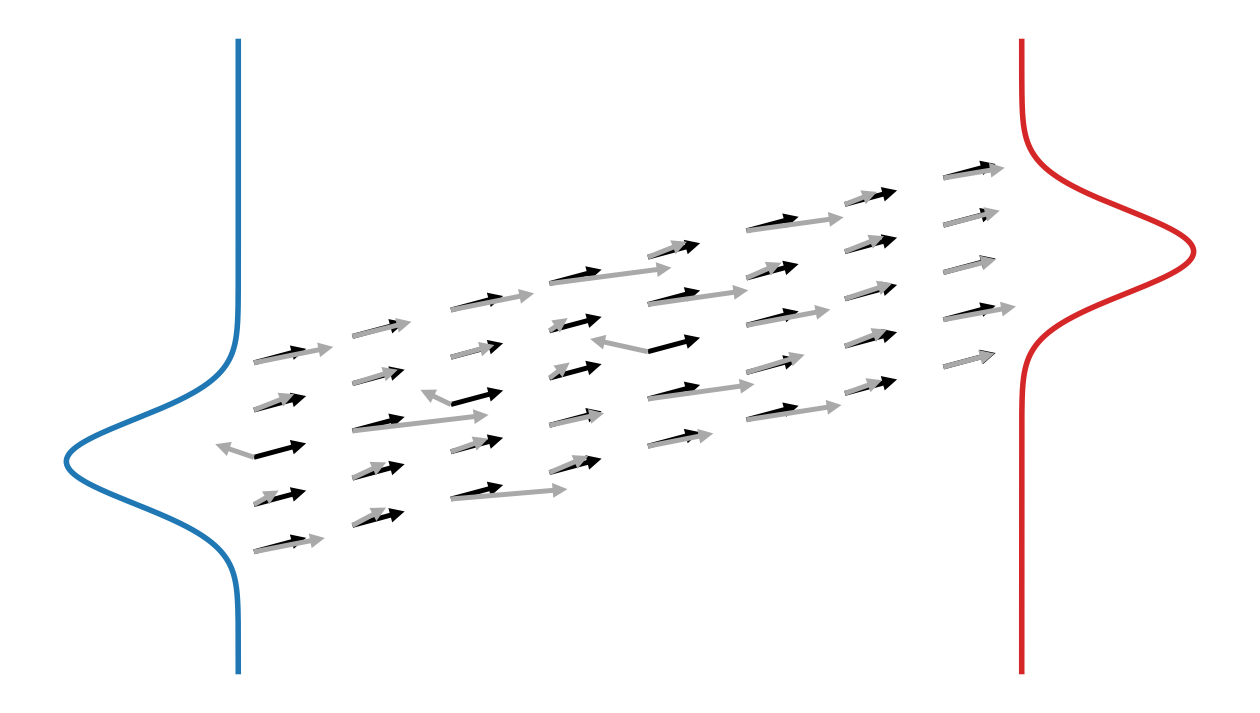

In [354]:
plt.figure(figsize=(16,9))

scale = .55
lw=4
# The pdf @ t=0
plt.plot(-scale*torch.exp(p_z0.log_prob(xx[:,None])),xx[:,None],'C0',lw=4)

# The pdf @ t=1
plt.plot(1+scale*torch.exp(p_z1.log_prob(xx[:,None])),xx[:,None],'C3',lw=4)

# Draw the arrows
kwargs = dict(angles='xy',scale_units='xy', scale=15,
              headwidth=3,headlength=3,headaxislength=3,
              width=.004)
plt.quiver(T, X, np.ones_like(X), mu*np.ones_like(X),
           **kwargs)

ax = plt.gca()
ax.spines[['left','right','top','bottom']].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.savefig('flow-matching-truth.pdf')

# Add noise on the truth labels to 
dx = .8*np.random.randn(*X.shape)
dy = .8*np.random.randn(*X.shape)

plt.quiver(T, X, 1+dx, mu+dy, color='darkgrey',**kwargs)

plt.savefig('flow-matching-param-arrows.pdf')

The actual flow mathcing loss function is:

$$\mathcal{L}  = \mathbb{E}_{t\sim \mathcal{U}[0,1]} \mathbb{E}_{x\sim p_t} \left[ || u_\theta(t,x) - u(t,x) ||^2\right]$$

which invoves sampling both from:
- $t \sim \mathrm{Unif}(0,1)$  
- $x \sim p_t$

So let's code this extra sampling step up!

In [358]:
# Sample some t points in the grid
Nt=40
Nx=1
t = torch.FloatTensor(np.random.uniform(size=Nt))

# Sample x points for each of these t
# xt = p_z0.sample_n(Nt).squeeze() +  mu*t

xt = torch.hstack([p_zt(ti).sample_n(Nx) for ti in t]) # (Nx,Nt)

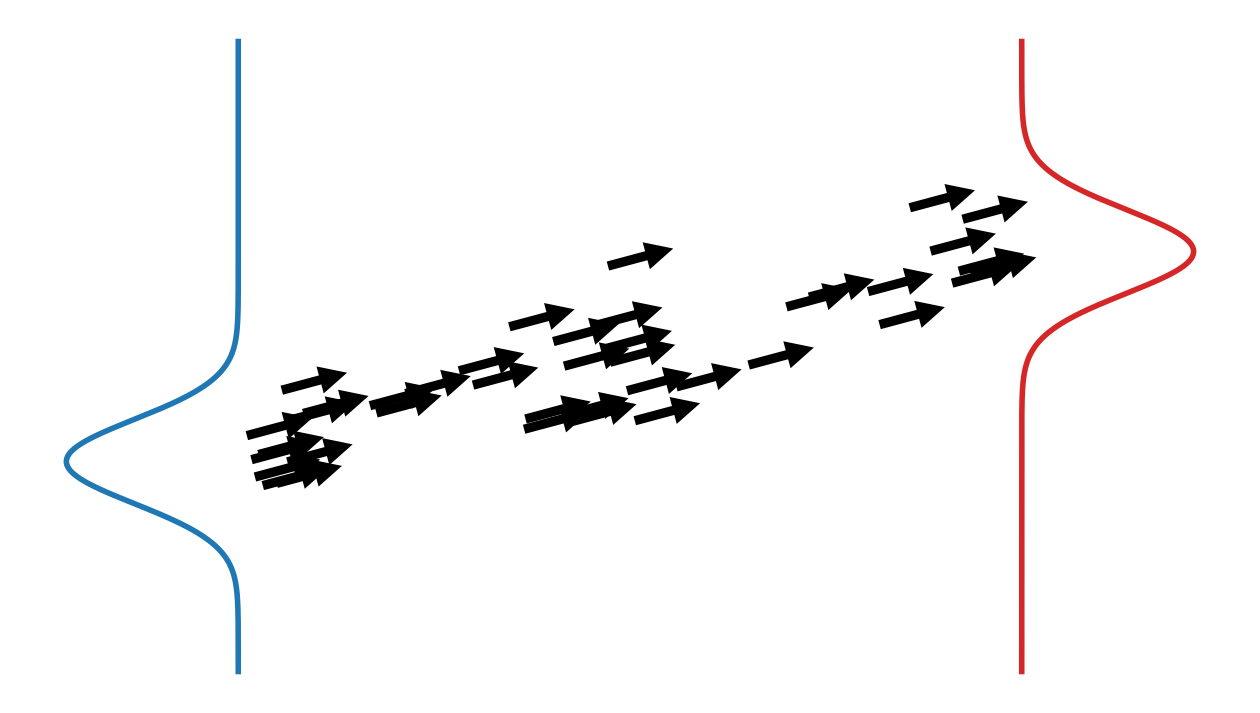

In [359]:
plt.figure(figsize=(16,9))

# The pdf @ t=0
plt.plot(-scale*torch.exp(p_z0.log_prob(xx[:,None])),xx[:,None],'C0',lw=4)

# The pdf @ t=1
plt.plot(1+scale*torch.exp(p_z1.log_prob(xx[:,None])),xx[:,None],'C3',lw=4)

plt.quiver(t[None,:]*np.ones_like(xt), xt,
           np.ones_like(xt),
           mu*np.ones_like(xt),
           angles='xy',scale_units='xy', scale=12,
           headwidth=3,headlength=3,headaxislength=3,
           color='k'
          )

# plt.vlines(t,*plt.ylim(),ls='dotted',lw=1,color='k')

ax = plt.gca()
ax.spines[['left','right','top','bottom']].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.savefig('figures/flow-matching-samples.pdf')


In [259]:
?plt.quiver

Signature: plt.quiver(*args, data=None, **kwargs)
Docstring:
Plot a 2D field of arrows.

Call signature::

  quiver([X, Y], U, V, [C], **kwargs)

*X*, *Y* define the arrow locations, *U*, *V* define the arrow directions, and
*C* optionally sets the color.

**Arrow length**

The default settings auto-scales the length of the arrows to a reasonable size.
To change this behavior see the *scale* and *scale_units* parameters.

**Arrow shape**

The arrow shape is determined by *width*, *headwidth*, *headlength* and
*headaxislength*. See the notes below.

**Arrow styling**

Each arrow is internally represented by a filled polygon with a default edge
linewidth of 0. As a result, an arrow is rather a filled area, not a line with
a head, and `.PolyCollection` properties like *linewidth*, *edgecolor*,
*facecolor*, etc. act accordingly.


Parameters
----------
X, Y : 1D or 2D array-like, optional
    The x and y coordinates of the arrow locations.

    If not given, they will be generated as a uni